In [1]:
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
import keras
import h5py
from keras.models import Sequential, Model
from keras.layers import Conv1D, Dropout, BatchNormalization, Activation, Input, UpSampling1D, Dense, Flatten, Lambda
from keras.optimizers import Adam

Using TensorFlow backend.


-> Batch_Normalization
-> ReLu

In [4]:
B = 4

In [5]:
import numpy as np
import tensorflow as tf

# ----------------------------------------------------------------------------

def SubPixel1D_v2(I, r):
  """One-dimensional subpixel upsampling layer
  Based on https://github.com/Tetrachrome/subpixel/blob/master/subpixel.py
  """
  with tf.name_scope('subpixel'):
    bsize, a, r = I.get_shape().as_list()
    bsize = tf.shape(I)[0] # Handling Dimension(None) type for undefined batch dim
    X = tf.split(1, a, I)  # a, [bsize, 1, r]
    if 'axis' in tf.squeeze.func_code.co_varnames:
      X = tf.concat(1, [tf.squeeze(x, axis=1) for x in X])  # bsize, a*r
    elif 'squeeze_dims' in tf.squeeze.func_code.co_varnames:
      X = tf.concat(1, [tf.squeeze(x, squeeze_dims=[1]) for x in X])  # bsize, a*r
    else:
      raise Exception('Unsupported version of tensorflow')
    return tf.reshape(X, (bsize, a*r, 1))

def SubPixel1D(I):
  """One-dimensional subpixel upsampling layer
  Calls a tensorflow function that directly implements this functionality.
  We assume input has dim (batch, width, r)
  """
  with tf.name_scope('subpixel'):
    X = tf.transpose(I, [2,1,0]) # (r, w, b)
    X = tf.batch_to_space_nd(X, [2], [[0,0]]) # (1, r*w, b)
    X = tf.transpose(X, [2,1,0])
    X = keras.backend.cast(X, dtype='float32')
    return X

#   X = keras.backend.permute_dimensions(I, [2,1,0])
#   X = tf.batch_to_space_nd(X, [r], [[0,0]]) # (1, r*w, b)
#   X = keras.backend.permute_dimensions(X, [2,1,0])
#   return X

    
def SubPixel1D_multichan(I, r):
  """One-dimensional subpixel upsampling layer
  Calls a tensorflow function that directly implements this functionality.
  We assume input has dim (batch, width, r).
  Works with multiple channels: (B,L,rC) -> (B,rL,C)
  """
  with tf.name_scope('subpixel'):
    _, w, rc = I.get_shape()
    assert rc % r == 0
    c = rc / r
    X = tf.transpose(I, [2,1,0]) # (rc, w, b)
    X = tf.batch_to_space_nd(X, [r], [[0,0]]) # (c, r*w, b)
    X = tf.transpose(X, [2,1,0])
    return X      

- The network below is a basic network
- Need to add Dimension shuffle and Stacking layers.

In [6]:
# Building the network

class My_Network_r():
    
    def __init__(self, optim = Adam(), loss = 'mean_squared_error'):
        self.optimizer = optim
        self.loss_func = loss
        self.ds_output = {}
        self.model = self.Create_Network()
    
    def Downsample_Layer(self,b, inp):
        n_filters = max(2**(6+b),512)
        k_size = min(2**(7-b)+1,9)
        x = Conv1D(filters=n_filters, kernel_size=k_size, strides = 2, padding='same')(inp)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        self.ds_output[b] = x
        print x.shape
        return x
    
    def Upsample_Layer(self,b, inp):
        print b
        n_filters = max(2**(7+(B-b+1)),512)
        k_size = min(2**(7-(B-b+1))+1,9)
        x = Conv1D(filters=n_filters, kernel_size=k_size, strides = 1, padding='same')(inp)
        print "conv {a}".format(a=x.shape)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
#         x = SubPixel1D(x, r=2)
        x = Lambda(SubPixel1D)(x)
        print "subpixel {a}".format(a=x.shape)
        x = keras.layers.concatenate([x, self.ds_output[B-b+1]], axis=2) #Should be 1?
        print "concat {a}".format(a=x.shape)
        return x
    
    def Create_Network(self):
        inputs = x = Input(shape=(2048,1))
        for i in range(1,B+2):
            x = self.Downsample_Layer(i,x)
        for i in range(1,B+1):
            x = self.Upsample_Layer(i,x)
        x = Conv1D(filters=2, kernel_size=9, strides = 1, padding='same')(x)
        x = Lambda(SubPixel1D)(x)
        model = Model(inputs=inputs, outputs=x)
        return model
        

In [7]:
music_model = My_Network_r()

(?, 1024, 512)
(?, 512, 512)
(?, 256, 512)
(?, 128, 1024)
(?, 64, 2048)
1
conv (?, 64, 2048)
subpixel (?, 128, 1024)
concat (?, 128, 2048)
2
conv (?, 128, 1024)
subpixel (?, 256, 512)
concat (?, 256, 1024)
3
conv (?, 256, 512)
subpixel (?, 512, 256)
concat (?, 512, 768)
4
conv (?, 512, 512)
subpixel (?, 1024, 256)
concat (?, 1024, 768)


In [8]:
music_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1024, 512)    5120        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024, 512)    2048        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1024, 512)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1d_2 (

In [9]:
music_model.model.compile(optimizer='Adam',loss = 'mean_squared_error', metrics = ['mae', 'accuracy'])

In [10]:
a = h5py.File('./output.h5', 'r')

In [11]:
import IPython.display as ipd

In [12]:
ipd.Audio(np.concatenate([a['label'][i,0:800,0] for i in range(0,1000)]), rate=16000)

In [13]:
ipd.Audio(np.concatenate([a['data'][i,0:200,0] for i in range(28032-1000,28032)]), rate=4000)

In [13]:
from scipy import interpolate

def spline_up(x_lr, r):
  x_lr = x_lr.flatten()
  x_hr_len = len(x_lr) * r
  x_sp = np.zeros(x_hr_len)
  
  i_lr = np.arange(x_hr_len, step=r)
  i_hr = np.arange(x_hr_len)
  
  f = interpolate.splrep(i_lr, x_lr)

  x_sp = interpolate.splev(i_hr, f)

  return x_sp

In [14]:

def spline4(x):
    return spline_up(x,4)
X = np.apply_along_axis(spline4, 1, a['data'])
y = a['label']

In [15]:
print X.shape
print y.shape

X_test = X[-1000:]
y_test = y[-1000:]
X = X[:-1000]
y = y[:-1000]

(28032, 2048, 1)
(28032, 2048, 1)


In [16]:
music_model.model.fit(X, y,  epochs=5, batch_size=128, shuffle="batch", verbose=1, validation_split=0.3)
# music_model.model.load_weights('model_polyB4.h5')

In [17]:
preds = music_model.model.predict(X_test)

# Original

In [24]:
ipd.Audio(np.concatenate([a['label'][i,0:800,0] for i in range(28032-1000,28032)]), rate=16000)

# Downsampled

In [19]:
ipd.Audio(np.concatenate([a['data'][i,0:200,0] for i in range(28032-1000,28032)]), rate=4000)

# Superresolved

In [20]:
ipd.Audio(np.concatenate([preds[i,0:800,0] for i in range(0,1000)]), rate=16000)

# Baseline

In [21]:
ipd.Audio(np.concatenate([X_test[i,0:800,0] for i in range(0,1000)]), rate=16000)

In [90]:
origwave = np.concatenate([a['label'][i,0:800,0] for i in range(28032-1000,28032)])
downwave = np.concatenate([a['data'][i,0:200,0] for i in range(28032-1000,28032)])
predwave = np.concatenate([preds[i,0:800,0] for i in range(0,1000)])
cubicwave = np.concatenate([X_test[i,0:800,0] for i in range(0,1000)])

In [91]:
#music_model.model.save_weights('model_polyB4.h5')

In [92]:
# import librosa
# librosa.output.write_wav('predwave.wav', predwave, sr=16000)

In [93]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

In [94]:
import librosa
def get_spectrum(x, n_fft=2048):
    S = librosa.stft(x, n_fft)
    p = np.angle(S)
    S = np.log1p(np.abs(S))
    return S

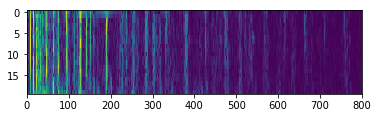

In [95]:
plt.imshow(get_spectrum(origwave[:10000], 2048).T, aspect=10)
plt.xlim([0,800])
plt.show()

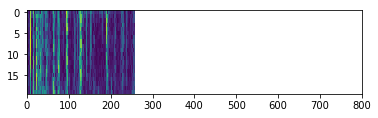

In [96]:
plt.imshow(get_spectrum(downwave[:2500], 2048/4).T, aspect = 10)
plt.xlim([0,800])
plt.show()

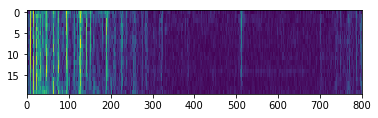

In [97]:
plt.imshow(get_spectrum(predwave[:10000], 2048).T, aspect=10)
plt.xlim([0,800])
plt.show()

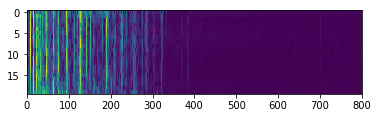

In [98]:
plt.imshow(get_spectrum(cubicwave[:10000], 2048).T, aspect=10)
plt.xlim([0,800])
plt.show()

In [99]:
origwave[:100]

array([-0.17428644, -0.161943  , -0.17934279, -0.14343251, -0.13870049,
       -0.17852168, -0.23192295, -0.26792097, -0.18492115, -0.05836263,
        0.0717824 ,  0.14690392,  0.15220821,  0.09974106, -0.03581712,
       -0.17741197, -0.30736861, -0.40416926, -0.49454626, -0.5598399 ,
       -0.54903954, -0.48748708, -0.37416655, -0.2764869 , -0.22252022,
       -0.21488854, -0.21262394, -0.19202867, -0.19875088, -0.18265788,
       -0.10729615, -0.03968629, -0.04421394, -0.04165417,  0.00437717,
        0.02223879, -0.00149245, -0.01978157,  0.01035294,  0.05914237,
        0.08538523,  0.0911056 ,  0.12003236,  0.17380027,  0.17656311,
        0.12848662,  0.09314009,  0.04555211, -0.0124816 , -0.0650915 ,
       -0.12365995, -0.06953526,  0.06168481,  0.20285881,  0.3325761 ,
        0.40152973,  0.42685878,  0.37408149,  0.29934922,  0.23390673,
        0.16292648,  0.07650229,  0.00342953, -0.02735466, -0.04213246,
       -0.00325842,  0.03585408,  0.05894688,  0.07080431,  0.06

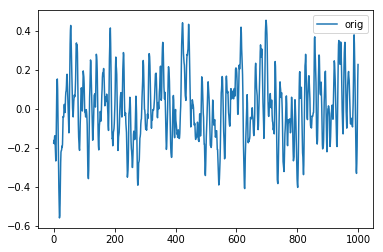

In [100]:
plt.plot(origwave[:1000], label="orig")
# plt.plot(cubicwave[:1000], label="cubic")
# plt.plot(predwave[:1000], label="pred")
plt.legend()
plt.show()

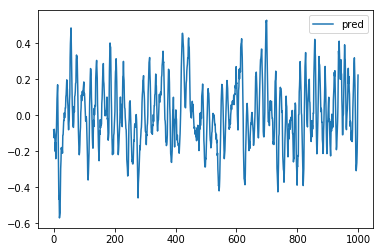

In [101]:
# plt.plot(origwave[:1000], label="orig")
# plt.plot(cubicwave[:1000], label="cubic")
plt.plot(predwave[:1000], label="pred")
plt.legend()
plt.show()

In [31]:
import librosa
librosa.output.write_wav("./baseline_sw.wav", np.concatenate([X_test[i,0:800,0] for i in range(0,1000)]),  16000)